# Mixture of Experts DL model

This model is a minimalist version of the Deepseek V3 MoE: https://arxiv.org/abs/2307.08696


In [1]:
from moe.model import MoEClassifier
from moe.data import generate_synthetic_data
from moe.visualize import data_visualization, training_visualization, expert_visualization

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import lightning as L
from lightning.pytorch.loggers import CSVLogger



In [2]:
%load_ext autoreload
%autoreload 2

## Generate data

In [3]:
n_clusters = 9
dim = 10
X, y = generate_synthetic_data(n_samples_per_pattern=200, dim=dim)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=64, shuffle=False)

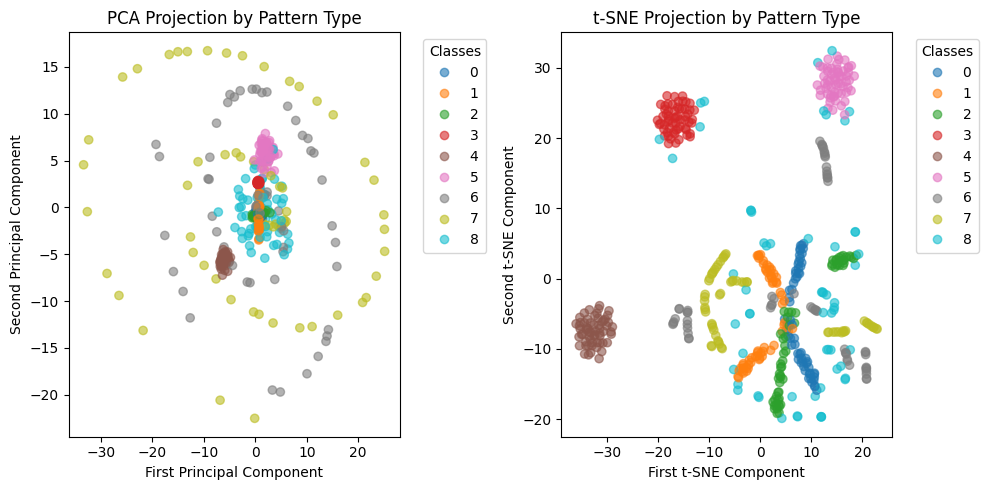

In [4]:
# Use the visualization
fig = data_visualization(X_test, y_test, figsize=(10,5))

## Train model

In [ ]:
model = MoEClassifier(dim=dim, n_experts=n_clusters, n_activated_experts=3)
# Get yhat and expert assignments before training
model.eval()
with torch.no_grad():
    pre_train_logits = model(torch.FloatTensor(X_test))
    y_hat_pre = pre_train_logits.argmax(dim=1).numpy()
pre_model_idx = model.get_expert_assignments(test_loader)

# Train model
trainer = L.Trainer(max_epochs=20,
                    logger=CSVLogger(save_dir="logs/", name="moe_experiment"))
trainer.fit(model, train_loader, test_loader)

# Get yhat and expert assignments after training
model.eval()
with torch.no_grad():
    pred_logits = model(torch.FloatTensor(X_test))
    y_hat = pred_logits.argmax(dim=1).numpy()
post_model_idx = model.get_expert_assignments(test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type       | Params | Mode
------------------------------------------------------
0 | moe             | MoE        | 4.0 K  | eval
1 | classifier_head | Sequential | 99     | eval
------------------------------------------------------
4.1 K     Trainable params
0         Non-trainable params
4.1 K     Total params
0.016     Total estimated model params size (MB)
0         Modules in train mode
42        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/divyar/miniconda3/envs/pytorch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/divyar/miniconda3/envs/pytorch/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/divyar/miniconda3/envs/pytorch/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## Visualize results

### Evaluate model performance

In [6]:
test_accuracy = accuracy_score(y_test, y_hat)
print(f"\nTest Accuracy: {test_accuracy:.4f}")

print(classification_report(y_test, y_hat))


Test Accuracy: 0.9204
              precision    recall  f1-score   support

           0       0.85      0.88      0.87        60
           1       0.85      0.85      0.85        60
           2       0.80      0.92      0.85        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        60
           5       0.98      1.00      0.99        60
           6       0.91      0.83      0.87        60
           7       1.00      0.97      0.98        60
           8       0.91      0.83      0.87        60

    accuracy                           0.92       540
   macro avg       0.92      0.92      0.92       540
weighted avg       0.92      0.92      0.92       540



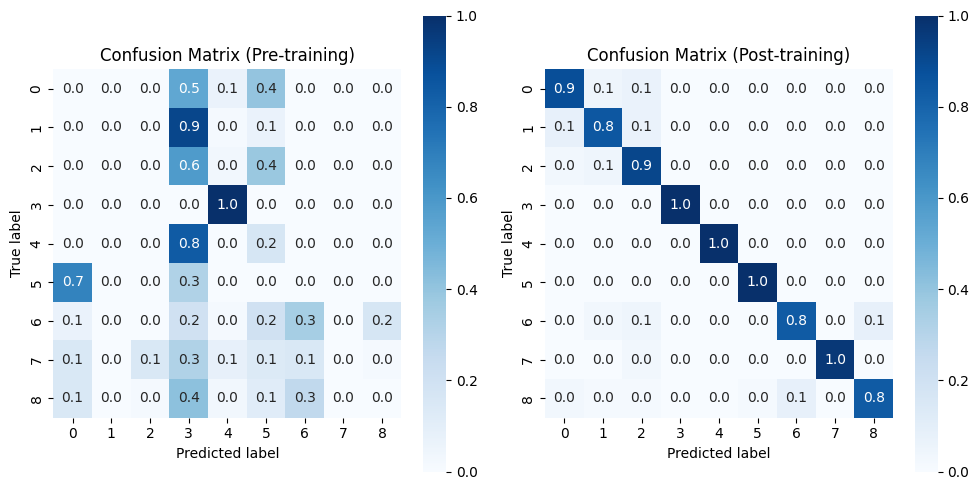

In [7]:
fig = training_visualization(X_test, y_test, y_hat_pre, y_hat, figsize=(10,5))

### Visualize learned expert patterns

The expert specialization heatmaps show two clustering metrics:

- **NMI (Normalized Mutual Information)**: Measures how well the expert assignments align with the true pattern labels. 
   Ranges from 0 (no mutual information) to 1 (perfect correlation).

 - **ARI (Adjusted Rand Index)**: Measures the similarity between expert assignments and true labels, adjusted for chance.
   Ranges from -1 to 1, where 1 indicates perfect agreement, 0 is random labeling, and negative values indicate less agreement than expected by chance.



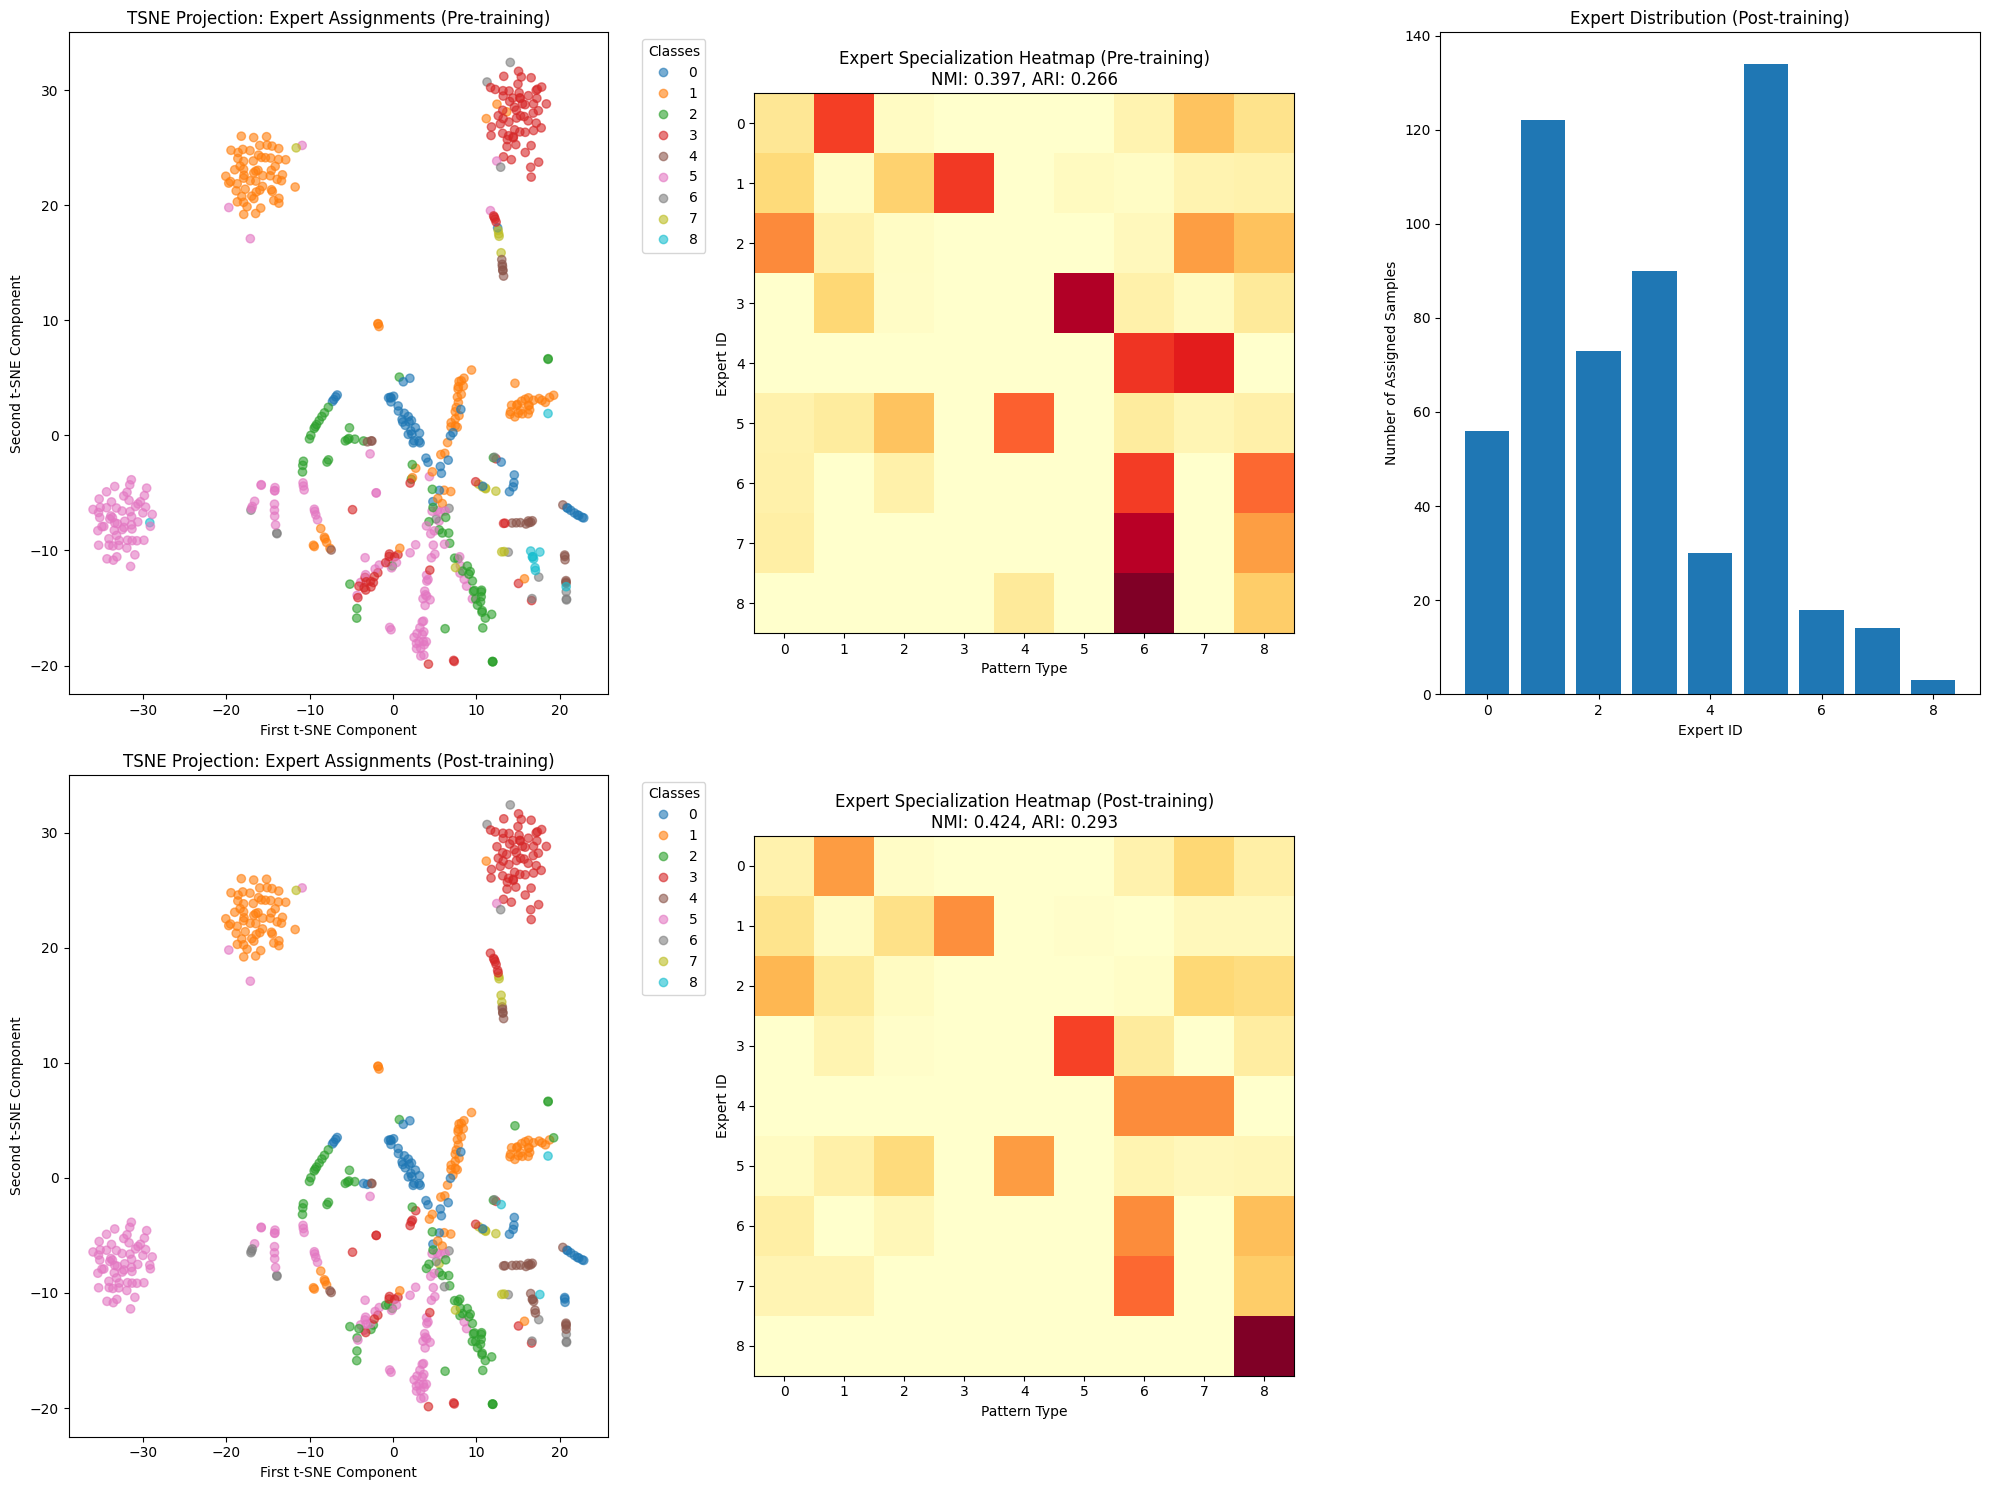

In [8]:
fig = expert_visualization(
    X_test, 
    y_test, 
    pre_model_idx[:, 0],  # Take the primary expert assignment
    post_model_idx[:, 0], 
    n_clusters
)

##### Why do we see a clustering effect in the expert assignments prior to training?

The clustering effect emerges naturally due to several factors:

1. **Data Structure**
   - The synthetic data has inherent clusters
   - Points within the same cluster are close to each other in the input space

2. **Network Architecture**
   - Due to the continuity of the linear+softmax transformation, similar inputs tend to get mapped to the same expert
   - This happens even before training because the random initialization creates arbitrary but consistent mappings

##### Mathematical Details

For two similar input vectors:
- Initial similarity: ||x₁ - x₂|| ≈ 0
- After linear transformation: ||W·x₁ + b - (W·x₂ + b)|| = ||W·(x₁ - x₂)||
- Because x₁ and x₂ are similar:
  - Their scores after the linear transformation will also be similar
  - The softmax function is continuous, so similar scores lead to similar probability distributions